In [1]:
import pandas as pd
import numpy as np

def load_stock_data(stock_name):
    bo_path = f"C:/Users/KIIT/Desktop/Stock-Market-Dashboard/cleaned_data/{stock_name}-bo.csv"
    ns_path = f"C:/Users/KIIT/Desktop/Stock-Market-Dashboard/cleaned_data/{stock_name}-ns.csv"

    bo_df = pd.read_csv(bo_path, parse_dates=['Date'], index_col='Date')
    ns_df = pd.read_csv(ns_path, parse_dates=['Date'], index_col='Date')
    
    combined_df = pd.concat([bo_df, ns_df]).sort_index()
    combined_df.drop(columns=['Anomaly'], errors='ignore', inplace=True)
    return combined_df


In [2]:
from sklearn.model_selection import train_test_split

def prepare_xgboost_data(df, sequence_length=60, horizon=5):
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns']
    
    df = df.dropna(subset=feature_cols)
    
    X, y = [], []
    for i in range(len(df) - sequence_length - horizon + 1):
        X.append(df.iloc[i:i+sequence_length][feature_cols].values)
        y.append(df.iloc[i+sequence_length:i+sequence_length+horizon]['Close'].values)
    
    X = np.array(X).reshape(len(X), -1)  # Flatten sequences for XGBoost
    y = np.array(y)
    
    return train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

def train_xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        objective='reg:squarederror',
        early_stopping_rounds=10  # Built-in early stopping
    )
    
    # Fit the model with eval_set for early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=True
    )
    
    # Evaluate Model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🎯 XGBoost MAE: {mae:.6f}")
    
    return model

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def predict_future(model, df, sequence_length=60, horizon=5):
    # Get the last sequence of data
    last_sequence = df.iloc[-sequence_length:][['Open','High','Low','Close','Volume','Returns']].values.flatten().reshape(1, -1)
    
    # Get predictions
    predictions = model.predict(last_sequence)[0]  # Extract the 1D array from the 2D prediction
    
    # Create time points for x-axis
    time_points = range(1, horizon + 1)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, predictions, marker='o', label="Predicted Close Price", color="orange")
    
    # Add last known price point for reference
    last_price = df['Close'].iloc[-1]
    plt.axhline(y=last_price, color='gray', linestyle='--', label='Last Known Price')
    
    # Customize the plot
    plt.title("Stock Price Prediction for Next 5 Days")
    plt.xlabel("Days Ahead")
    plt.ylabel("Price")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Add price annotations
    for i, price in enumerate(predictions):
        plt.annotate(f'{price:.2f}', 
                    (time_points[i], price),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')
    
    plt.tight_layout()
    plt.show()

    return predictions


In [18]:
import os

def find_similar_stocks(target_returns, stock_folder, tolerance=0.02):
    similar_stocks = []
    
    for file in os.listdir(stock_folder):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(stock_folder, file))
            avg_return = df['Returns'].mean()
            if abs(avg_return - target_returns) <= tolerance:
                similar_stocks.append(file.replace('.csv', ''))
    
    return similar_stocks


[0]	validation_0-rmse:613.44765
[1]	validation_0-rmse:583.61537
[2]	validation_0-rmse:555.29209
[3]	validation_0-rmse:528.37377
[4]	validation_0-rmse:502.78564
[5]	validation_0-rmse:478.40118
[6]	validation_0-rmse:455.27834
[7]	validation_0-rmse:433.23892
[8]	validation_0-rmse:412.33027
[9]	validation_0-rmse:392.44429
[10]	validation_0-rmse:373.52898
[11]	validation_0-rmse:355.50981
[12]	validation_0-rmse:338.34989
[13]	validation_0-rmse:322.10413
[14]	validation_0-rmse:306.67772
[15]	validation_0-rmse:292.05017
[16]	validation_0-rmse:278.18166
[17]	validation_0-rmse:264.99724
[18]	validation_0-rmse:252.43341
[19]	validation_0-rmse:240.53513
[20]	validation_0-rmse:229.23660
[21]	validation_0-rmse:218.51805
[22]	validation_0-rmse:208.36294
[23]	validation_0-rmse:198.73641
[24]	validation_0-rmse:189.63126
[25]	validation_0-rmse:180.97489
[26]	validation_0-rmse:172.75321
[27]	validation_0-rmse:164.95517
[28]	validation_0-rmse:157.56478
[29]	validation_0-rmse:150.61395
[30]	validation_0-rm

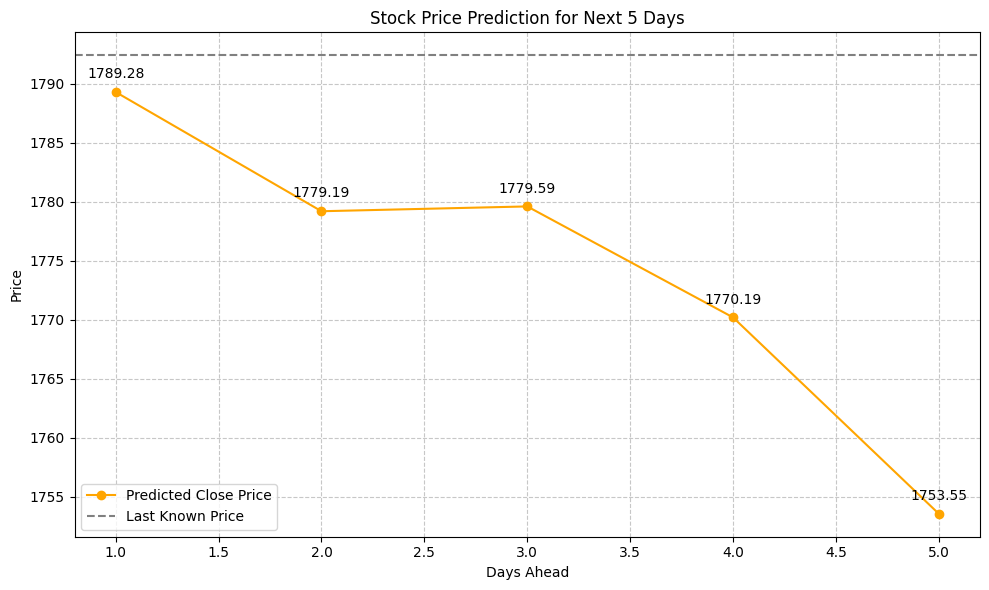

📊 Average Return of ACC: 0.000224
📈 Stocks with similar performance: 20MICRONS-bo, 20MICRONS-ns, 3MINDIA-bo, 3MINDIA-ns, 3PLAND-ns, 5PAISA-bo, 5PAISA-ns, 63MOONS-bo, 63MOONS-ns, A2ZINFRA-bo, A2ZINFRA-ns, AARTIDRUGS-bo, AARTIDRUGS-ns, AARTIIND-bo, AARTIIND-ns, AARVEEDEN-bo, AARVEEDEN-ns, ABAN-bo, ABAN-ns, ABB-bo, ABB-ns, ABBOTINDIA-bo, ABBOTINDIA-ns, ABCAPITAL-bo, ABCAPITAL-ns, ABFRL-bo, ABFRL-ns, ACC-bo, ACC-ns, ACCELYA-bo, ACCELYA-ns, ACE-ns, ADANIENT-bo, ADANIENT-ns, ADANIPORTS-bo, ADANIPORTS-ns, ADANIPOWER-bo, ADANIPOWER-ns, ADFFOODS-bo, ADFFOODS-ns, ADORWELD-bo, ADROITINFO-ns, ADSL-bo, ADSL-ns, ADVANIHOTR-bo, ADVANIHOTR-ns, ADVENZYMES-bo, ADVENZYMES-ns, AGARIND-bo, AGARIND-ns, AGRITECH-bo, AGRITECH-ns, AGROPHOS-ns, AHLEAST-bo, AHLEAST-ns, AHLUCONT-ns, AIAENG-bo, AIRAN-ns, AJANTPHARM-bo, AJANTPHARM-ns, AJMERA-bo, AJMERA-ns, AKSHOPTFBR-bo, AKSHOPTFBR-ns, AKZOINDIA-ns, ALANKIT-bo, ALANKIT-ns, ALBERTDAVD-ns, ALEMBICLTD-bo, ALEMBICLTD-ns, ALICON-bo, ALICON-ns, ALKALI-bo, ALKALI-ns, ALKE

In [19]:
if __name__ == "__main__":
    stock_name = input("Enter Stock Name: ").strip().upper()
    df = load_stock_data(stock_name)
    
    X_train, X_test, y_train, y_test = prepare_xgboost_data(df)
    
    model = train_xgboost(X_train, X_test, y_train, y_test)
    
    predictions = predict_future(model, df)
    
    avg_return = df['Returns'].mean()
    print(f"📊 Average Return of {stock_name}: {avg_return:.6f}")
    
    similar = find_similar_stocks(avg_return, "C:/Users/KIIT/Desktop/Stock-Market-Dashboard/cleaned_data")
    print(f"📈 Stocks with similar performance: {', '.join(similar) if similar else 'None'}")


In [20]:
# %% [Save Work]
import joblib

# Save model, datasets, and predictions
joblib.dump(model, 'xgboost_model.joblib')
joblib.dump((X_train, X_test, y_train, y_test), 'xgboost_data_splits.joblib')
joblib.dump(predictions, 'xgboost_predictions.joblib')

print("✅ Work saved: Model, data splits, and predictions.")


✅ Work saved: Model, data splits, and predictions.


🔄 Loading and preparing data...
🚀 Training model...
📊 Evaluating model...

📊 Model Performance:
MAE: 28.61
RMSE: 39.98


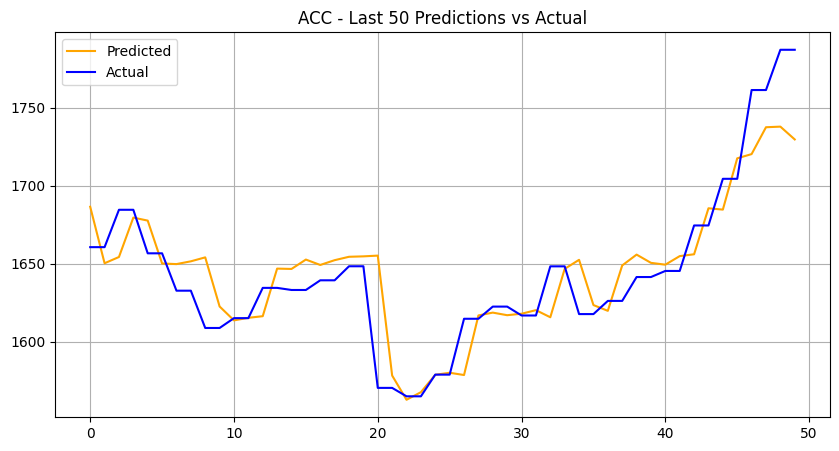

In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

def enhance_features(df):
    """Lightweight feature engineering - only essential indicators"""
    # Simple moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    
    # Basic momentum
    df['Price_Momentum'] = df['Close'].pct_change(periods=5)
    
    # Simple volatility
    df['Volatility'] = df['Close'].rolling(window=10).std()
    
    # Volume features
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    
    return df

def prepare_optimized_data(df, sequence_length=30):  # Reduced sequence length
    """Prepare data with basic scaling and essential features"""
    # Add technical indicators
    df = enhance_features(df)
    
    # Reduced feature set
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns',
                   'MA5', 'MA20', 'Price_Momentum', 'Volatility', 'Volume_MA5']
    
    # Drop rows with NaN values
    df = df.dropna(subset=feature_cols)
    
    # Scale features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[feature_cols]), 
                           columns=feature_cols, 
                           index=df.index)
    
    # Prepare sequences - using numpy for better performance
    X = np.zeros((len(df_scaled) - sequence_length - 4, sequence_length * len(feature_cols)))
    y = np.zeros((len(df_scaled) - sequence_length - 4, 5))
    
    for i in range(len(df_scaled) - sequence_length - 4):
        X[i] = df_scaled.iloc[i:i+sequence_length][feature_cols].values.flatten()
        y[i] = df.iloc[i+sequence_length:i+sequence_length+5]['Close'].values
    
    # Simple train-test split - last 20% for testing
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test, scaler

def train_fast_xgboost(X_train, X_test, y_train, y_test):
    """Simplified XGBoost training with preset parameters"""
    model = xgb.XGBRegressor(
        n_estimators=100,  # Reduced number of trees
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',  # Faster histogram-based algorithm
        early_stopping_rounds=10
    )
    
    # Train with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False  # Reduced logging for speed
    )
    
    return model

def quick_evaluate(model, X_test, y_test):
    """Basic model evaluation"""
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    print(f"\n📊 Model Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    return predictions

def plot_predictions(predictions, y_test, stock_name):
    """Simple prediction plot"""
    plt.figure(figsize=(10, 5))
    plt.plot(predictions[-50:, 0], label='Predicted', color='orange')
    plt.plot(y_test[-50:, 0], label='Actual', color='blue')
    plt.title(f'{stock_name} - Last 50 Predictions vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_fast_model(stock_name):
    """Main function for quick model training and evaluation"""
    print("🔄 Loading and preparing data...")
    df = load_stock_data(stock_name)
    X_train, X_test, y_train, y_test, scaler = prepare_optimized_data(df)
    
    print("🚀 Training model...")
    model = train_fast_xgboost(X_train, X_test, y_train, y_test)
    
    print("📊 Evaluating model...")
    predictions = quick_evaluate(model, X_test, y_test)
    
    plot_predictions(predictions, y_test, stock_name)
    
    return model, scaler

if __name__ == "__main__":
    stock_name = input("Enter Stock Name: ").strip().upper()
    model, scaler = train_fast_model(stock_name)

🔄 Loading and preparing data...
🚀 Training model...
📊 Evaluating model...

📊 Model Performance:
MAE: 16.48
RMSE: 24.78


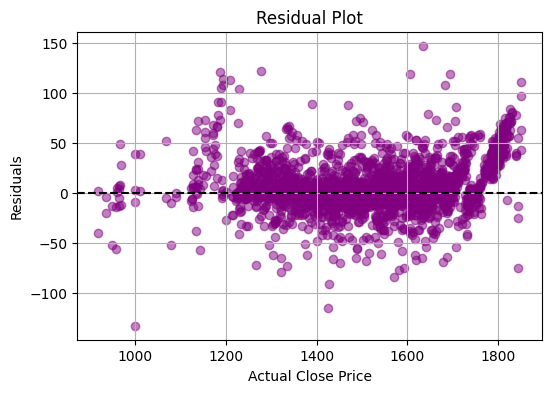

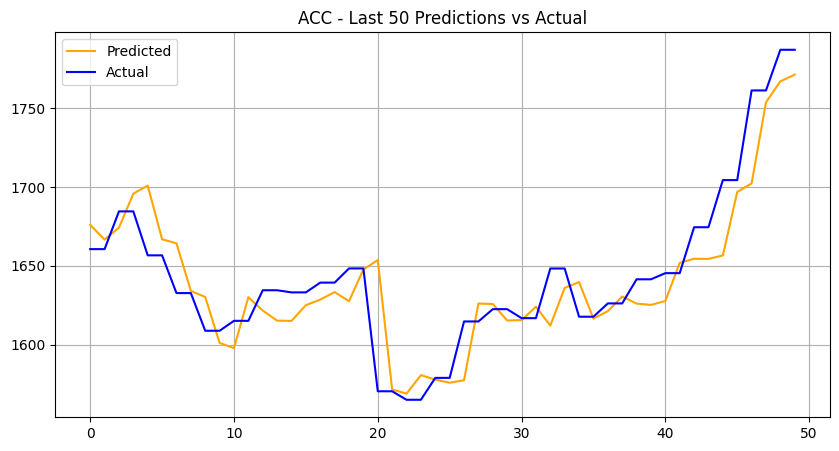

In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

### FEATURE ENGINEERING ###
def enhance_features(df):
    """Enhanced feature engineering with more indicators."""
    # Moving Averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['EMA10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['Rolling_Median'] = df['Close'].rolling(window=10).median()

    # Momentum and Volatility
    df['Price_Momentum'] = df['Close'].pct_change(periods=5)
    df['Volatility'] = df['Close'].rolling(window=10).std()

    # Lag Features (previous days’ closes)
    df['Lag_1'] = df['Close'].shift(1)
    df['Lag_2'] = df['Close'].shift(2)

    # Time-based Features
    df['Day_of_Week'] = df.index.dayofweek

    # Volume Feature
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

    return df

### DATA PREPARATION ###
def prepare_optimized_data(df, sequence_length=60):
    """Prepare data with enhanced features and robust scaling."""
    df = enhance_features(df)

    # Feature set
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns',
                    'MA5', 'EMA10', 'Rolling_Median', 'Price_Momentum',
                    'Volatility', 'Lag_1', 'Lag_2', 'Day_of_Week', 'Volume_MA5']
    
    df = df.dropna(subset=feature_cols)
    
    # Scaling with RobustScaler
    scaler = RobustScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[feature_cols]), 
                             columns=feature_cols, 
                             index=df.index)
    
    # Sequence Preparation
    X = np.zeros((len(df_scaled) - sequence_length - 4, sequence_length * len(feature_cols)))
    y = np.zeros((len(df_scaled) - sequence_length - 4, 5))

    for i in range(len(df_scaled) - sequence_length - 4):
        X[i] = df_scaled.iloc[i:i+sequence_length][feature_cols].values.flatten()
        y[i] = df.iloc[i+sequence_length:i+sequence_length+5]['Close'].values

    # Train-test split (80-20)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X_train, X_test, y_train, y_test, scaler

### MODEL TRAINING ###
def train_fast_xgboost(X_train, X_test, y_train, y_test):
    """XGBoost training with improved parameters."""
    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='reg:squarederror',
        tree_method='hist',
        early_stopping_rounds=20
    )

    model.fit(
        X_train, y_train[:, 0],
        eval_set=[(X_test, y_test[:, 0])],
        verbose=False
    )

    return model

### EVALUATION ###
def quick_evaluate(model, X_test, y_test):
    """Model evaluation with multiple metrics and plots."""
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:, 0], predictions)
    rmse = np.sqrt(mean_squared_error(y_test[:, 0], predictions))
    
    print(f"\n📊 Model Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # Residual Plot
    plt.figure(figsize=(6,4))
    plt.scatter(y_test[:, 0], y_test[:, 0] - predictions, color='purple', alpha=0.5)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Actual Close Price')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True)
    plt.show()

    return predictions

### PLOTTING ###
def plot_predictions(predictions, y_test, stock_name):
    """Enhanced prediction plot for multiple horizons."""
    plt.figure(figsize=(10, 5))
    plt.plot(predictions[-50:], label='Predicted', color='orange')
    plt.plot(y_test[-50:, 0], label='Actual', color='blue')
    plt.title(f'{stock_name} - Last 50 Predictions vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

### MAIN FUNCTION ###
def train_fast_model(stock_name):
    """Pipeline for data loading, model training, and evaluation."""
    print("🔄 Loading and preparing data...")
    df = load_stock_data(stock_name)
    X_train, X_test, y_train, y_test, scaler = prepare_optimized_data(df)

    print("🚀 Training model...")
    model = train_fast_xgboost(X_train, X_test, y_train, y_test)

    print("📊 Evaluating model...")
    predictions = quick_evaluate(model, X_test, y_test)

    plot_predictions(predictions, y_test, stock_name)

    return model, scaler

if __name__ == "__main__":
    stock_name = input("Enter Stock Name: ").strip().upper()
    model, scaler = train_fast_model(stock_name)


🔄 Preparing data...
🚀 Training model...
[0]	validation_0-rmse:626.71564
[100]	validation_0-rmse:24.26922
[162]	validation_0-rmse:23.30647
📊 Evaluating model...

📊 Model Performance:
MAE: 15.70
RMSE: 23.26


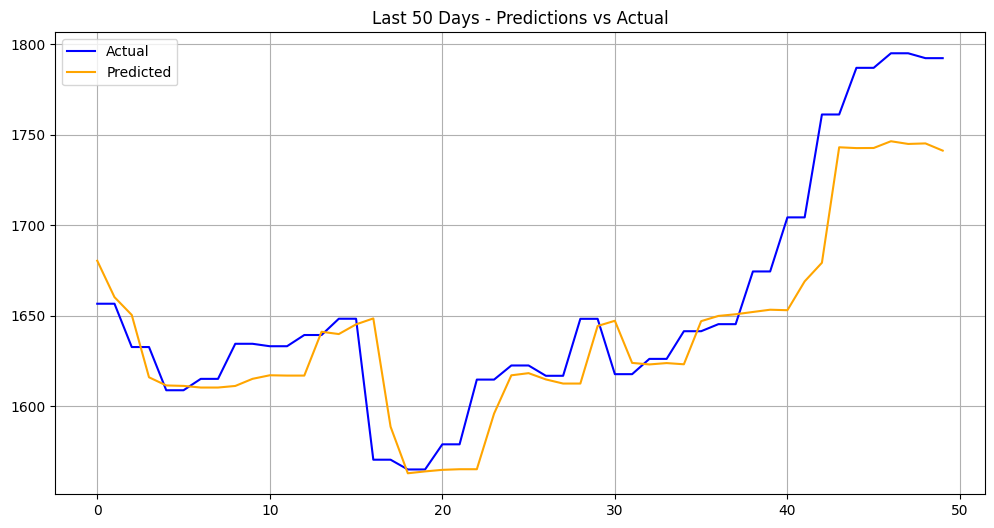

🔮 Predicting future prices...
Predicted prices for next 5 days: [1741.2732 2028.0225 2062.5757 2050.422  1535.295 ]


In [27]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

def create_features(df):
    """Enhanced feature engineering without external dependencies."""
    # Exponential Moving Average (EMA)
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    
    # Average True Range (ATR)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    df['TR'] = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = df['TR'].rolling(window=14).mean()
    
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Volume indicators
    df['Volume_MA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_STD'] = df['Volume'].rolling(window=20).std()
    
    return df

def prepare_data(df, sequence_length=20):
    """Prepare data for time series prediction."""
    # Create features
    df = create_features(df)
    
    # Select features
    feature_cols = ['Close', 'Volume', 'EMA_20', 'ATR', 'RSI', 'MACD', 
                   'MACD_Signal', 'Volume_MA', 'Volume_STD']
    
    # Drop NaN values
    df = df.dropna()
    
    # Scale features
    scaler = RobustScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[feature_cols]),
        columns=feature_cols,
        index=df.index
    )
    
    # Create sequences for time series prediction
    X, y = [], []
    for i in range(len(df_scaled) - sequence_length):
        X.append(df_scaled.iloc[i:i+sequence_length].values)
        y.append(df['Close'].iloc[i+sequence_length])
    
    X = np.array(X)
    y = np.array(y)
    
    # Split into train and test (last 20% for testing)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler

def train_model(X_train, X_test, y_train, y_test):
    """Train XGBoost model with optimized parameters."""
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        early_stopping_rounds=20,
        random_state=42
    )
    
    # Reshape data for XGBoost (flatten sequences)
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    
    # Train model
    model.fit(
        X_train_2d, 
        y_train,
        eval_set=[(X_test_2d, y_test)],
        verbose=100
    )
    
    return model

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance and create visualizations."""
    # Reshape test data
    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    
    # Make predictions
    y_pred = model.predict(X_test_2d)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n📊 Model Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[-50:], label='Actual', color='blue')
    plt.plot(y_pred[-50:], label='Predicted', color='orange')
    plt.title('Last 50 Days - Predictions vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return y_pred

def predict_future(model, last_sequence, scaler, n_days=5):
    """Predict future stock prices."""
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_days):
        # Reshape sequence for prediction
        current_sequence_2d = current_sequence.reshape(1, -1)
        
        # Make prediction
        next_pred = model.predict(current_sequence_2d)[0]
        predictions.append(next_pred)
        
        # Update sequence for next prediction
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_pred
    
    return np.array(predictions)

def main(stock_data):
    """Main function to run the stock prediction pipeline."""
    print("🔄 Preparing data...")
    X_train, X_test, y_train, y_test, scaler = prepare_data(stock_data)
    
    print("🚀 Training model...")
    model = train_model(X_train, X_test, y_train, y_test)
    
    print("📊 Evaluating model...")
    y_pred = evaluate_model(model, X_test, y_test)
    
    print("🔮 Predicting future prices...")
    future_pred = predict_future(model, X_test[-1], scaler)
    print(f"Predicted prices for next 5 days: {future_pred}")
    
    return model, scaler

if __name__ == "__main__":
    # Load your stock data here
    stock_name = input("Enter Stock Name: ").strip().upper()
    df = load_stock_data(stock_name)
    model, scaler = main(df)

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class EnhancedStockPredictor:
    def __init__(self, sequence_length=20, n_splits=5):
        self.sequence_length = sequence_length
        self.n_splits = n_splits
        self.scaler = RobustScaler()
        self.feature_importance = None
        
    def create_advanced_features(self, df):
        """Enhanced feature engineering with market psychology indicators."""
        # Price-based features
        df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
        df['Price_Range'] = (df['High'] - df['Low']) / df['Close']
        df['Price_Acceleration'] = df['Close'].diff().diff()
        
        # Volatility features
        df['Historical_Vol'] = df['Log_Return'].rolling(window=20).std() * np.sqrt(252)
        df['Volatility_Ratio'] = df['Historical_Vol'] / df['Historical_Vol'].rolling(window=50).mean()
        
        # Volume analysis
        df['Volume_Price_Trend'] = (df['Close'] - df['Close'].shift(1)) * df['Volume']
        df['Volume_Force'] = df['Volume_Price_Trend'].ewm(span=13).mean()
        
        # Technical indicators
        # Enhanced RSI with smoothing
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        df['RSI_MA'] = df['RSI'].rolling(window=10).mean()
        
        # Enhanced MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
        
        # Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
        df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
        
        # Market sentiment features
        df['Price_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
        df['Price_Momentum'] = df['Close'] / df['Close'].rolling(window=10).mean() - 1
        
        return df
        
    def prepare_sequences(self, df):
        """Prepare data sequences with enhanced feature selection."""
        # Select final feature set
        feature_cols = ['Close', 'Volume', 'Log_Return', 'Price_Range', 'Historical_Vol',
                       'Volume_Force', 'RSI', 'RSI_MA', 'MACD', 'MACD_Hist', 
                       'BB_Width', 'Price_Position', 'Price_Momentum']
        
        df = df.dropna()
        
        # Scale features
        scaled_data = self.scaler.fit_transform(df[feature_cols])
        df_scaled = pd.DataFrame(scaled_data, columns=feature_cols, index=df.index)
        
        # Create sequences
        X, y = [], []
        for i in range(len(df_scaled) - self.sequence_length):
            X.append(df_scaled.iloc[i:i+self.sequence_length].values)
            y.append(df['Close'].iloc[i+self.sequence_length])
            
        return np.array(X), np.array(y), feature_cols
    
    def train_model(self, X, y):
        """Train model with time series cross-validation and hyperparameter optimization."""
        # Reshape data for XGBoost
        X_2d = X.reshape(X.shape[0], -1)
        
        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        
        models = []
        cv_scores = []
        
        for train_idx, val_idx in tscv.split(X_2d):
            X_train, X_val = X_2d[train_idx], X_2d[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = xgb.XGBRegressor(
                n_estimators=300,
                learning_rate=0.03,
                max_depth=6,
                min_child_weight=2,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0.1,
                tree_method='hist',
                early_stopping_rounds=30,
                random_state=42
            )
            
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=100
            )
            
            y_pred = model.predict(X_val)
            score = r2_score(y_val, y_pred)
            cv_scores.append(score)
            models.append(model)
        
        # Select best model
        best_model_idx = np.argmax(cv_scores)
        self.model = models[best_model_idx]
        print(f"\nCross-validation R² scores: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
        
        return self.model
    
    def analyze_predictions(self, X_test, y_test):
        """Comprehensive prediction analysis and visualization."""
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        y_pred = self.model.predict(X_test_2d)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        print("\n📊 Model Performance:")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R²: {r2:.4f}")
        
        # Create visualization subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Predictions vs Actual
        axes[0,0].plot(y_test[-50:], label='Actual', color='blue')
        axes[0,0].plot(y_pred[-50:], label='Predicted', color='orange')
        axes[0,0].set_title('Last 50 Days - Predictions vs Actual')
        axes[0,0].legend()
        axes[0,0].grid(True)
        
        # Residuals
        residuals = y_test - y_pred
        axes[0,1].scatter(y_pred, residuals, alpha=0.5)
        axes[0,1].axhline(y=0, color='r', linestyle='--')
        axes[0,1].set_title('Residual Analysis')
        axes[0,1].set_xlabel('Predicted Values')
        axes[0,1].set_ylabel('Residuals')
        
        # QQ Plot
        stats.probplot(residuals, dist="norm", plot=axes[1,0])
        axes[1,0].set_title('Q-Q Plot')
        
        # Feature Importance
        feature_importance = pd.DataFrame({
            'feature': [f'feature_{i}' for i in range(X_test_2d.shape[1])],
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        sns.barplot(x='importance', y='feature', data=feature_importance.head(10), ax=axes[1,1])
        axes[1,1].set_title('Top 10 Feature Importance')
        
        plt.tight_layout()
        plt.show()
        
        return y_pred, residuals

def run_prediction(stock_data):
    """Main function to run the enhanced prediction pipeline."""
    predictor = EnhancedStockPredictor()
    
    print("🔄 Preparing enhanced features...")
    df = predictor.create_advanced_features(stock_data)
    
    print("🎯 Creating sequences...")
    X, y, feature_cols = predictor.prepare_sequences(df)
    
    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print("🚀 Training model with cross-validation...")
    model = predictor.train_model(X_train, y_train)
    
    print("📊 Analyzing predictions...")
    y_pred, residuals = predictor.analyze_predictions(X_test, y_test)
    
    return predictor, y_pred, residuals

🔄 Preparing enhanced features...
🎯 Creating sequences...
🚀 Training model with cross-validation...
[0]	validation_0-rmse:1344.94848
[100]	validation_0-rmse:140.93006
[200]	validation_0-rmse:103.35950
[299]	validation_0-rmse:102.10834
[0]	validation_0-rmse:556.95269
[100]	validation_0-rmse:95.17425
[107]	validation_0-rmse:96.45514
[0]	validation_0-rmse:244.03934
[100]	validation_0-rmse:93.03316
[200]	validation_0-rmse:92.10644
[204]	validation_0-rmse:92.12783
[0]	validation_0-rmse:349.80958
[100]	validation_0-rmse:23.43136
[200]	validation_0-rmse:14.94685
[229]	validation_0-rmse:14.96720
[0]	validation_0-rmse:581.16653
[100]	validation_0-rmse:33.63954
[200]	validation_0-rmse:17.57295
[296]	validation_0-rmse:17.45873

Cross-validation R² scores: -0.6626 (±2.9106)
📊 Analyzing predictions...

📊 Model Performance:
MAE: 18.87
RMSE: 28.79
R²: 0.9706


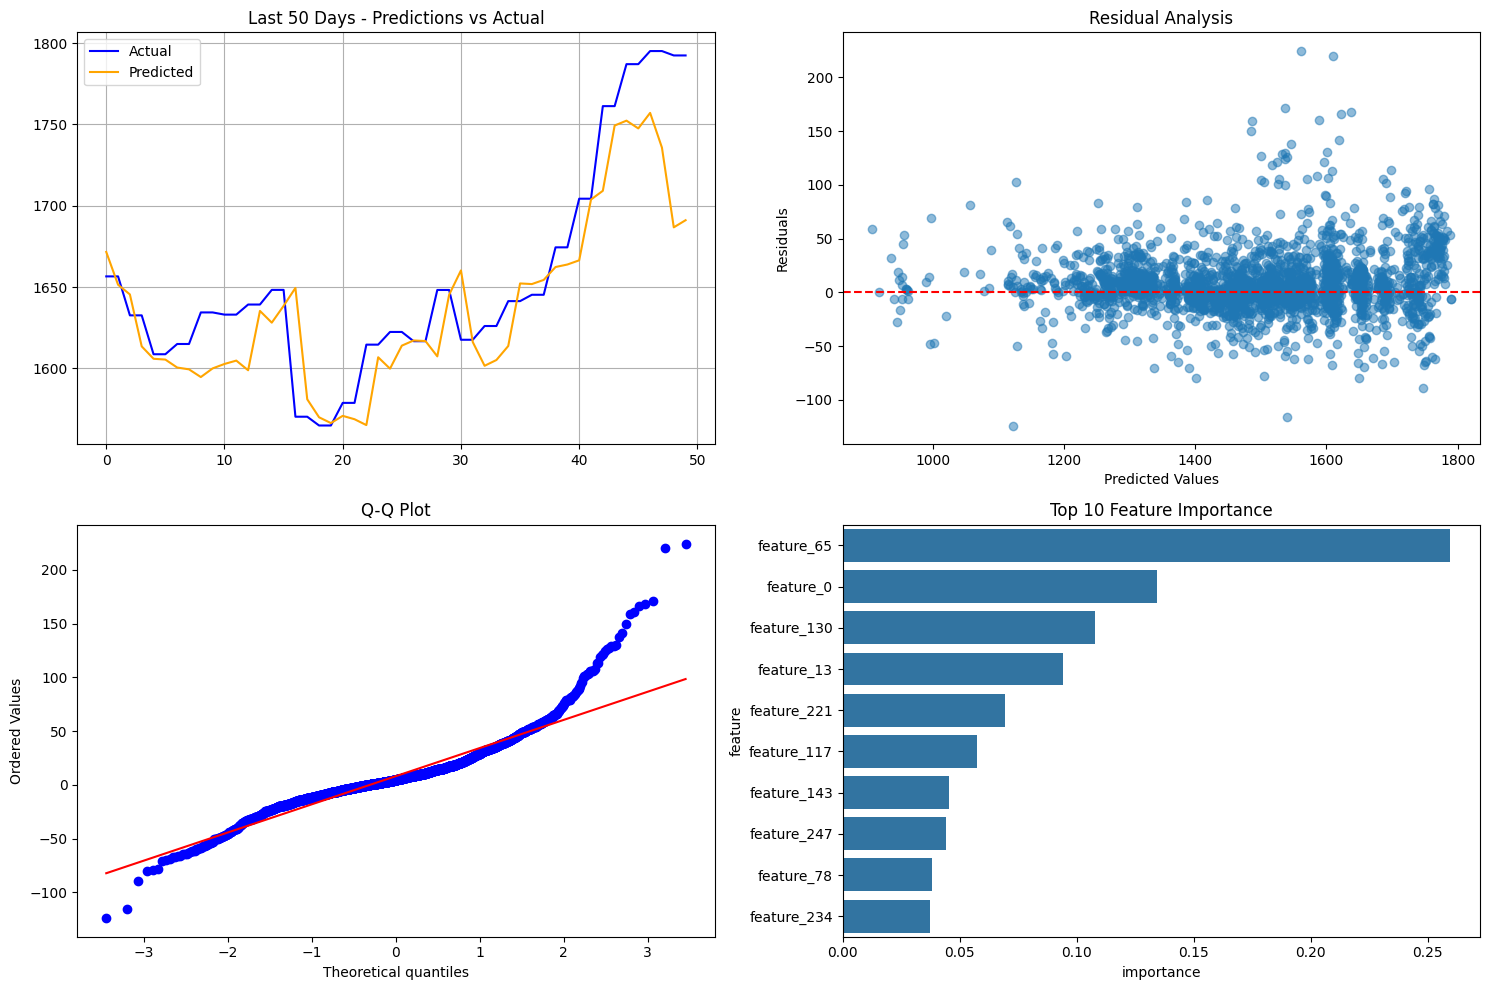

In [31]:
# Load your stock data
df = load_stock_data('ACC')

# Run the enhanced prediction pipeline
predictor, predictions, residuals = run_prediction(df)

In [36]:
import joblib
joblib.dump(model, f"{stock_name}_xgb_model.pkl")
joblib.dump(scaler, f"{stock_name}_scaler.pkl")


['ACC_scaler.pkl']

Plotting Feature Importance...


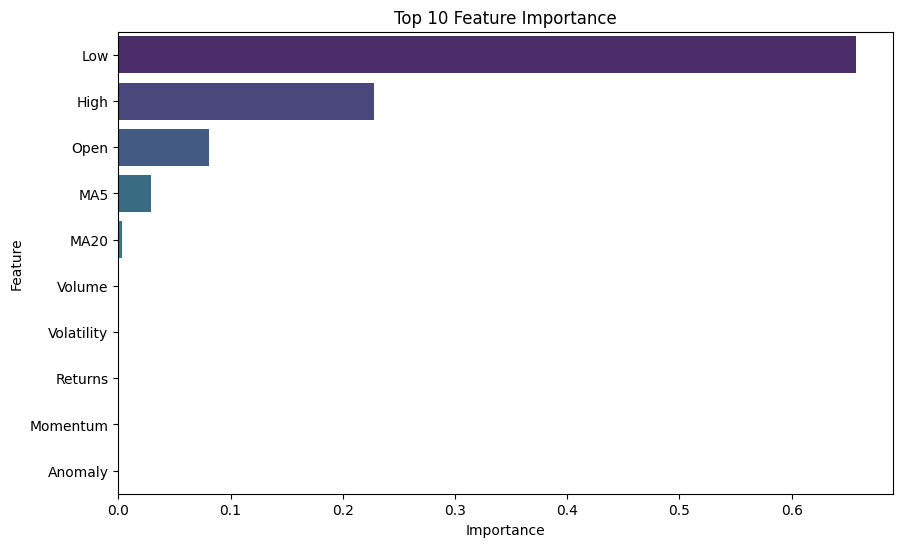

Selected 4 important features: ['Open', 'High', 'Low', 'MA5']
Selected 4 important features: ['Open', 'High', 'Low', 'MA5']
MAE: 11.76
RMSE: 16.78
R²: 0.9900


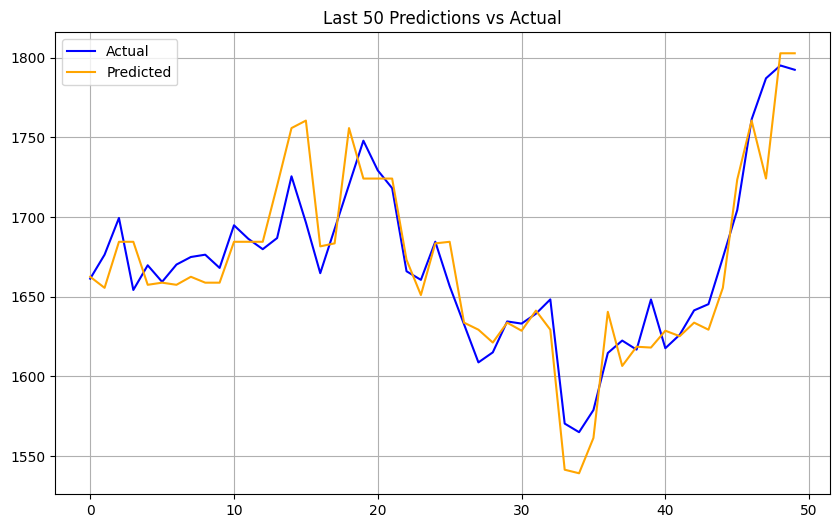

In [41]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and Prepare Data
def load_data(file_path):
    """Load stock data and preprocess."""
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    df['Returns'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df

def feature_engineering(df):
    """Add technical indicators for feature engineering."""
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Close'].rolling(window=10).std()
    df['Momentum'] = df['Close'].diff(5)
    return df.dropna()

def prepare_data(df, target_column='Close'):
    """Prepare data for training."""
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    return X_train, X_test, y_train, y_test

# 2. Train Model and Analyze Feature Importance
def train_xgboost(X_train, y_train):
    """Train an XGBoost model."""
    model = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        random_state=42
    )
    
    model.fit(X_train, y_train)
    return model

def plot_feature_importance(model, feature_names):
    """Plot top 10 feature importance."""
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title('Top 10 Feature Importance')
    plt.show()

# 3. Dimensionality Reduction
def select_important_features(model, X):
    """Select only the most important features."""
    importance_threshold = 0.01  # Set a threshold for importance
    important_features = [
        feature for feature, importance in zip(X.columns, model.feature_importances_)
        if importance >= importance_threshold
    ]
    
    print(f"Selected {len(important_features)} important features: {important_features}")
    
    return X[important_features]

# 4. Evaluate Model Performance
def evaluate_model(model, X_test, y_test):
    """Evaluate the model and plot predictions."""
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Plot predictions vs actuals
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values[-50:], label="Actual", color="blue")
    plt.plot(y_pred[-50:], label="Predicted", color="orange")
    plt.title("Last 50 Predictions vs Actual")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Pipeline
if __name__ == "__main__":
    
    # Step 1: Load and preprocess data
    file_path = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\cleaned_data\ACC-bo.csv"
    data = load_data(file_path)
    
    # Step 2: Feature engineering
    data = feature_engineering(data)
    
    # Step 3: Split data into training and testing sets
    X_train, X_test, y_train, y_test = prepare_data(data)
    
    # Step 4: Train the initial model and analyze feature importance
    initial_model = train_xgboost(X_train, y_train)
    
    print("Plotting Feature Importance...")
    plot_feature_importance(initial_model, X_train.columns)
    
    # Step 5: Select important features and retrain the model
    X_train_reduced = select_important_features(initial_model, X_train)
    X_test_reduced = select_important_features(initial_model, X_test)
    
    final_model = train_xgboost(X_train_reduced, y_train)
    
    # Step 6: Evaluate the final model
    evaluate_model(final_model, X_test_reduced, y_test)


In [43]:
# Hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [300, 400, 500],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

# RandomizedSearchCV with TimeSeriesSplit
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(tree_method='hist', random_state=42),
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=2,
    n_jobs=-1
)

# Train on reduced features
X_train_reduced = X_train[['Low', 'High', 'Open', 'MA5']]
X_test_reduced = X_test[['Low', 'High', 'Open', 'MA5']]

random_search.fit(X_train_reduced, y_train)

# Best model evaluation
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_reduced)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Optimized MAE: {mae:.2f}")
print(f"Optimized RMSE: {rmse:.2f}")
print(f"Optimized R²: {r2:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimized MAE: 12.61
Optimized RMSE: 18.35
Optimized R²: 0.9881


In [47]:
# Hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [300, 400, 500],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

# RandomizedSearchCV with TimeSeriesSplit
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(tree_method='hist', random_state=42),
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=2,
    n_jobs=-1
)

# Train on reduced features
X_train_reduced = X_train[['Low', 'High', 'Open', 'MA5']]
X_test_reduced = X_test[['Low', 'High', 'Open', 'MA5']]

random_search.fit(X_train_reduced, y_train)

# Best model evaluation
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_reduced)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Optimized MAE: {mae:.2f}")
print(f"Optimized RMSE: {rmse:.2f}")
print(f"Optimized R²: {r2:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimized MAE: 11.98
Optimized RMSE: 17.72
Optimized R²: 0.9889


In [51]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from skopt import BayesSearchCV
import pandas as pd
import numpy as np
import xgboost as xgb

def calculate_rsi(series, window=14):
    """Calculate the Relative Strength Index (RSI)."""
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean() + 1e-6  # Avoid division by zero
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(series):
    """Calculate the Moving Average Convergence Divergence (MACD)."""
    ema12 = series.ewm(span=12, adjust=False).mean()
    ema26 = series.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    return macd

def calculate_bollinger_bands(series, window=20, num_std=2):
    """Calculate Bollinger Bands."""
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    bb_upper = sma + (std * num_std)
    bb_lower = sma - (std * num_std)
    return bb_upper, sma, bb_lower

# Optional: If you have an existing basic feature engineering function, define it here.
def enhance_features(df):
    # Placeholder for existing feature engineering steps.
    return df

def enhance_features_advanced(df):
    """Enhanced feature engineering with advanced technical indicators."""
    # Uncomment the following line if you want to include previous feature engineering.
    # df = enhance_features(df)
    
    # Add advanced technical indicators using the helper functions
    df['RSI'] = calculate_rsi(df['Close'], window=14)
    df['MACD'] = calculate_macd(df['Close'])
    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'])
    
    # Price patterns
    df['Price_Range'] = df['High'] - df['Low']
    df['Price_Change'] = df['Close'].diff()
    df['Returns_Volatility'] = df['Returns'].rolling(window=10).std()
    
    # Volume analysis
    df['Volume_Price_Ratio'] = df['Volume'] / df['Close']
    df['Volume_Trend'] = df['Volume'].pct_change()
    
    return df

def optimize_xgboost_params(X_train, y_train):
    """Hyperparameter optimization using Bayesian Optimization"""
    from sklearn.model_selection import TimeSeriesSplit
    
    param_space = {
        'n_estimators': (100, 500),
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.1, 'log-uniform'),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0),
        'min_child_weight': (1, 7),
        'gamma': (0, 0.5)
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42
    )
    
    optimizer = BayesSearchCV(
        xgb_model,
        param_space,
        cv=tscv,
        n_iter=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    optimizer.fit(X_train, y_train)
    return optimizer.best_estimator_

def train_ensemble_model(X_train, y_train, X_test, y_test):
    """Train an ensemble of models"""
    # Base XGBoost model
    xgb_model = optimize_xgboost_params(X_train, y_train)
    
    # LightGBM model
    lgb_model = LGBMRegressor(
        objective='regression',
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42
    )
    
    # Train models and get predictions
    models = [xgb_model, lgb_model]
    predictions = []
    
    for model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        predictions.append(pred)
    
    # Ensemble predictions (weighted average)
    final_predictions = 0.6 * predictions[0] + 0.4 * predictions[1]
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, final_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
    r2 = r2_score(y_test, final_predictions)
    
    return final_predictions, mae, rmse, r2, (xgb_model, lgb_model)

In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

def prepare_optimized_data(df, target_column='Close', test_size=0.2, random_state=42):
    """
    Prepare data for training by selecting features, dropping missing values,
    scaling, and splitting into train/test sets.
    """
    # Define features that exist after enhance_features_advanced
    feature_cols = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
        'BB_Upper', 'BB_Middle', 'BB_Lower', 'Price_Range',
        'Price_Change', 'Returns_Volatility', 'Volume_Price_Ratio', 'Volume_Trend'
    ]
    
    # Ensure that the target column does not overlap with features.
    # For example, if predicting next-day price, you might shift:
    df['Target'] = df[target_column].shift(-1)
    
    # Drop rows with NaN in features or target
    df = df.dropna(subset=feature_cols + ['Target'])
    
    # Scaling features
    scaler = RobustScaler()
    X = scaler.fit_transform(df[feature_cols])
    y = df['Target'].values

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    
    return X_train, X_test, y_train, y_test

In [54]:
if __name__ == "__main__":
    # Load and prepare data
    stock_name = input("Enter Stock Name: ").strip().upper()
    df = load_stock_data(stock_name)
    df = enhance_features_advanced(df)

    X_train, X_test, y_train, y_test = prepare_optimized_data(df)
    predictions, mae, rmse, r2, models = train_ensemble_model(X_train, y_train, X_test, y_test)
    
    # Calculate relative MAE
    avg_price = df['Close'].mean()
    relative_mae = (mae / avg_price) * 100
    
    print(f"Relative MAE: {relative_mae:.2f}%")
    print(f"RMSE/MAE Ratio: {rmse/mae:.2f}")
    print(f"R² Score: {r2:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [55]:
import joblib

# After training your ensemble model, assume you have:
# predictions, mae, rmse, r2, models = train_ensemble_model(X_train, y_train, X_test, y_test)
# where models is a tuple: (xgb_model, lgb_model)

# Save your ensemble models (and any other artifacts like your scaler if needed)
model_artifacts = {
    'xgb_model': models[0],
    'lgb_model': models[1],
    # 'scaler': scaler,      # include scaler if you need to transform new data
    # You can add additional items such as feature names or model metrics
}

joblib.dump(model_artifacts, 'ensemble_model.joblib')
print("✅ Model saved as ensemble_model.joblib")

✅ Model saved as ensemble_model.joblib


In [56]:
import joblib

# Load the saved model artifacts
model_artifacts = joblib.load('ensemble_model.joblib')
xgb_model = model_artifacts['xgb_model']
lgb_model = model_artifacts['lgb_model']

# Example: Making predictions with your ensemble models
def ensemble_predict(X_new, weight_xgb=0.6, weight_lgb=0.4):
    pred_xgb = xgb_model.predict(X_new)
    pred_lgb = lgb_model.predict(X_new)
    return weight_xgb * pred_xgb + weight_lgb * pred_lgb

# X_new should be preprocessed using the same scaler or feature engineering steps applied during training

In [57]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from lightgbm import LGBMRegressor

# Define advanced feature engineering helper functions
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean() + 1e-6  # Avoid division by zero
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_macd(series):
    ema12 = series.ewm(span=12, adjust=False).mean()
    ema26 = series.ewm(span=26, adjust=False).mean()
    return ema12 - ema26

def calculate_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    bb_upper = sma + (std * num_std)
    bb_lower = sma - (std * num_std)
    return bb_upper, sma, bb_lower

def enhance_features_advanced(df):
    # Advanced technical indicators
    df['RSI'] = calculate_rsi(df['Close'], window=14)
    df['MACD'] = calculate_macd(df['Close'])
    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'])
    
    # Price patterns
    df['Price_Range'] = df['High'] - df['Low']
    df['Price_Change'] = df['Close'].diff()
    df['Returns_Volatility'] = df['Returns'].rolling(window=10).std() if 'Returns' in df.columns else np.nan
    
    # Volume analysis
    df['Volume_Price_Ratio'] = df['Volume'] / df['Close']
    df['Volume_Trend'] = df['Volume'].pct_change()
    
    return df

# Prepare data for prediction
def prepare_optimized_data(df, target_column='Close'):
    # Define features based on your engineered columns
    feature_cols = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
        'BB_Upper', 'BB_Middle', 'BB_Lower', 'Price_Range',
        'Price_Change', 'Returns_Volatility', 'Volume_Price_Ratio', 'Volume_Trend'
    ]
    # Create target column (predict next day's close)
    df['Target'] = df[target_column].shift(-1)
    
    # Drop rows with missing values in features or target
    df = df.dropna(subset=feature_cols + ['Target'])
    
    # Scale the features
    scaler = RobustScaler()
    X = scaler.fit_transform(df[feature_cols])
    y = df['Target'].values
    
    return X, y, scaler

# Ensemble prediction function
def ensemble_predict(X_new, weight_xgb=0.6, weight_lgb=0.4):
    pred_xgb = model_artifacts['xgb_model'].predict(X_new)
    pred_lgb = model_artifacts['lgb_model'].predict(X_new)
    return weight_xgb * pred_xgb + weight_lgb * pred_lgb

# Load cleaned CSV file for ABB stock
csv_path = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\cleaned_data\ABB-ns.csv"
df = pd.read_csv(csv_path)

# Apply advanced feature engineering
df = enhance_features_advanced(df)

# Prepare data (features X, actual target y, and scaler if needed for later use)
X, y, scaler = prepare_optimized_data(df, target_column='Close')

# Load saved ensemble model artifacts (make sure ensemble_model.joblib is in your working directory)
model_artifacts = joblib.load("ensemble_model.joblib")

# Make predictions with the ensemble model
predictions = ensemble_predict(X)

# Calculate accuracy metrics
mae = mean_absolute_error(y, predictions)
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 298.65
RMSE: 355.89
R² Score: 0.7393


In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
import joblib

# ----- Step 1: Data Quality & Enhanced Feature Engineering -----
def clean_and_enhance_data(df):
    """
    Clean the DataFrame by handling missing values/outliers and applying
    enhanced feature engineering.
    """
    # Ensure proper date formatting if a Date column exists
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)
        df.reset_index(drop=True, inplace=True)
    
    # Remove outliers using quantile filtering for key numeric columns
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        if col in df.columns:
            q_low = df[col].quantile(0.01)
            q_high = df[col].quantile(0.99)
            df = df[(df[col] >= q_low) & (df[col] <= q_high)]
    
    # Compute basic returns if not present
    if 'Returns' not in df.columns and 'Close' in df.columns:
        df['Returns'] = df['Close'].pct_change()
    
    # Apply enhanced feature engineering
    df = enhance_features_advanced(df)
    
    return df

def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean() + 1e-6  # Avoid div/zero
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_macd(series):
    ema12 = series.ewm(span=12, adjust=False).mean()
    ema26 = series.ewm(span=26, adjust=False).mean()
    return ema12 - ema26

def calculate_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    return sma + num_std * std, sma, sma - num_std * std

def enhance_features_advanced(df):
    """
    Add advanced technical indicators and price/volume pattern features.
    """
    # Technical indicators
    df['RSI'] = calculate_rsi(df['Close'], window=14)
    df['MACD'] = calculate_macd(df['Close'])
    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'])
    
    # Price pattern features
    df['Price_Range'] = df['High'] - df['Low']
    df['Price_Change'] = df['Close'].diff()
    # Use Returns if available; else, fill with NaN and later drop rows.
    df['Returns_Volatility'] = df['Returns'].rolling(window=10).std() if 'Returns' in df.columns else np.nan
    
    # Volume analysis
    df['Volume_Price_Ratio'] = df['Volume'] / df['Close']
    df['Volume_Trend'] = df['Volume'].pct_change()
    
    return df

# ----- Step 2: Redefine Target Column -----
def prepare_data_new_target(df, target_type='price', test_size=0.2, random_state=42):
    """
    Create features and a new target.
    If target_type is 'price' then predict next-day Close.
    If target_type is 'return', predict the next-day percent change.
    """
    feature_cols = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
        'BB_Upper', 'BB_Middle', 'BB_Lower', 'Price_Range',
        'Price_Change', 'Returns_Volatility', 'Volume_Price_Ratio', 'Volume_Trend'
    ]
    
    # Create target based on option
    if target_type == 'price':
        df['Target'] = df['Close'].shift(-1)
    elif target_type == 'return':
        df['Target'] = df['Close'].pct_change().shift(-1)
    else:
        raise ValueError("target_type must be either 'price' or 'return'")
    
    # Drop rows that have NaNs in features or target
    df = df.dropna(subset=feature_cols + ['Target'])
    
    # Scale features
    scaler = RobustScaler()
    X = scaler.fit_transform(df[feature_cols])
    y = df['Target'].values
    
    # Split the data (for time series leave shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    
    return X_train, X_test, y_train, y_test, scaler

# ----- Step 3: Enhanced Hyperparameter Tuning for XGBoost -----
def optimize_xgboost_params_v2(X_train, y_train):
    """
    Extended hyperparameter optimization for xgboost with an expanded parameter grid.
    """
    param_space = {
        'n_estimators': (100, 800),
        'max_depth': (3, 12),
        'learning_rate': (0.005, 0.2, 'log-uniform'),
        'subsample': (0.5, 1.0, 'uniform'),
        'colsample_bytree': (0.5, 1.0, 'uniform'),
        'min_child_weight': (1, 10),
        'gamma': (0, 1.0, 'uniform')
    }
    tscv = TimeSeriesSplit(n_splits=5)
    
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42
    )
    
    optimizer = BayesSearchCV(
        xgb_model,
        param_space,
        cv=tscv,
        n_iter=100,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    optimizer.fit(X_train, y_train)
    print("Best XGBoost parameters:", optimizer.best_params_)
    return optimizer.best_estimator_

# Example usage: predict stock prices from CSV file and check accuracy
if __name__ == "__main__":
    # Load CSV data for ABB stock (adjust the path as needed)
    csv_path = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\cleaned_data\ABB-ns.csv"
    df = pd.read_csv(csv_path)
    
    # Step 1: Clean and enhance features
    df = clean_and_enhance_data(df)
    
    # Step 2: Prepare data; choose target_type 'price' for next-day Close or 'return' for percent change
    X_train, X_test, y_train, y_test, scaler = prepare_data_new_target(df, target_type='price')
    
    # Step 3: Optimize XGBoost parameters
    best_xgb = optimize_xgboost_params_v2(X_train, y_train)
    
    # Train a LightGBM model (using basic parameters; tune as needed)
    lgb_model = LGBMRegressor(
        objective='regression',
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42
    )
    lgb_model.fit(X_train, y_train)
    
    # Save the ensemble models (xgboost and lightgbm) for later predictions
    model_artifacts = {
        'xgb_model': best_xgb,
        'lgb_model': lgb_model,
        'scaler': scaler  # Save scaler for future data transformation
    }
    joblib.dump(model_artifacts, "ensemble_model_improved.joblib")
    print("✅ Saved improved ensemble model to ensemble_model_improved.joblib")
    
    # Ensemble predictions (weighted average)
    def ensemble_predict(X, weight_xgb=0.6, weight_lgb=0.4):
        pred_xgb = best_xgb.predict(X)
        pred_lgb = lgb_model.predict(X)
        return weight_xgb * pred_xgb + weight_lgb * pred_lgb
    
    predictions = ensemble_predict(X_test)
    
    # Calculate performance metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
import joblib

# ----- Step 1: Data Quality & Enhanced Feature Engineering -----
def clean_and_enhance_data(df):
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)
        df.reset_index(drop=True, inplace=True)
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        if col in df.columns:
            q_low = df[col].quantile(0.01)
            q_high = df[col].quantile(0.99)
            df = df[(df[col] >= q_low) & (df[col] <= q_high)]
    if 'Returns' not in df.columns and 'Close' in df.columns:
        df['Returns'] = df['Close'].pct_change()
    df = enhance_features_advanced(df)
    return df

def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean() + 1e-6
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_macd(series):
    ema12 = series.ewm(span=12, adjust=False).mean()
    ema26 = series.ewm(span=26, adjust=False).mean()
    return ema12 - ema26

def calculate_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    return sma + num_std * std, sma, sma - num_std * std

def enhance_features_advanced(df):
    df['RSI'] = calculate_rsi(df['Close'], window=14)
    df['MACD'] = calculate_macd(df['Close'])
    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'])
    df['Price_Range'] = df['High'] - df['Low']
    df['Price_Change'] = df['Close'].diff()
    df['Returns_Volatility'] = df['Returns'].rolling(window=10).std() if 'Returns' in df.columns else np.nan
    df['Volume_Price_Ratio'] = df['Volume'] / df['Close']
    df['Volume_Trend'] = df['Volume'].pct_change()
    return df

# ----- Step 2: Redefine Target Column -----
def prepare_data_new_target(df, target_type='price', test_size=0.2, random_state=42):
    feature_cols = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
        'BB_Upper', 'BB_Middle', 'BB_Lower', 'Price_Range',
        'Price_Change', 'Returns_Volatility', 'Volume_Price_Ratio', 'Volume_Trend'
    ]
    if target_type == 'price':
        df['Target'] = df['Close'].shift(-1)
    elif target_type == 'return':
        df['Target'] = df['Close'].pct_change().shift(-1)
    else:
        raise ValueError("target_type must be either 'price' or 'return'")
    df = df.dropna(subset=feature_cols + ['Target'])
    scaler = RobustScaler()
    X = scaler.fit_transform(df[feature_cols])
    y = df['Target'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    return X_train, X_test, y_train, y_test, scaler

# ----- Step 3: Enhanced Hyperparameter Tuning for XGBoost -----
def optimize_xgboost_params_v2(X_train, y_train):
    param_space = {
        'n_estimators': (100, 800),
        'max_depth': (3, 12),
        'learning_rate': (0.005, 0.2, 'log-uniform'),
        'subsample': (0.5, 1.0, 'uniform'),
        'colsample_bytree': (0.5, 1.0, 'uniform'),
        'min_child_weight': (1, 10),
        'gamma': (0, 1.0, 'uniform')
    }
    tscv = TimeSeriesSplit(n_splits=5)
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42
    )
    optimizer = BayesSearchCV(
        xgb_model,
        param_space,
        cv=tscv,
        n_iter=100,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0,  # Set verbose to 0 to suppress fold fit messages
        random_state=42
    )
    optimizer.fit(X_train, y_train)
    return optimizer.best_estimator_

if __name__ == "__main__":
    csv_path = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\cleaned_data\ABB-ns.csv"
    df = pd.read_csv(csv_path)
    df = clean_and_enhance_data(df)
    X_train, X_test, y_train, y_test, scaler = prepare_data_new_target(df, target_type='price')
    best_xgb = optimize_xgboost_params_v2(X_train, y_train)
    lgb_model = LGBMRegressor(
        objective='regression',
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42
    )
    lgb_model.fit(X_train, y_train)
    model_artifacts = {
        'xgb_model': best_xgb,
        'lgb_model': lgb_model,
        'scaler': scaler
    }
    joblib.dump(model_artifacts, "ensemble_model_improved.joblib")
    # Ensemble predictions (weighted average)
    def ensemble_predict(X, weight_xgb=0.6, weight_lgb=0.4):
        pred_xgb = best_xgb.predict(X)
        pred_lgb = lgb_model.predict(X)
        return weight_xgb * pred_xgb + weight_lgb * pred_lgb
    predictions = ensemble_predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 4483, number of used features: 15
[LightGBM] [Info] Start training from score 787.451497
MAE: 20.59
RMSE: 27.87
R² Score: 0.9808


In [62]:
import pandas as pd
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the saved model artifacts
model_artifacts = joblib.load('ensemble_model_improved.joblib')
xgb_model = model_artifacts['xgb_model']
lgb_model = model_artifacts['lgb_model']
scaler = model_artifacts['scaler']

# Define the function to enhance features
def enhance_features_advanced(df):
  def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean() + 1e-6
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

  def calculate_macd(series):
    ema12 = series.ewm(span=12, adjust=False).mean()
    ema26 = series.ewm(span=26, adjust=False).mean()
    return ema12 - ema26

  def calculate_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    return sma + num_std * std, sma, sma - num_std * std

  df['RSI'] = calculate_rsi(df['Close'], window=14)
  df['MACD'] = calculate_macd(df['Close'])
  df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'])
  df['Price_Range'] = df['High'] - df['Low']
  df['Price_Change'] = df['Close'].diff()
  df['Returns_Volatility'] = df['Returns'].rolling(window=10).std() if 'Returns' in df.columns else np.nan
  df['Volume_Price_Ratio'] = df['Volume'] / df['Close']
  df['Volume_Trend'] = df['Volume'].pct_change()
  return df

# Load and preprocess the new data
csv_path = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\cleaned_data\ABCAPITAL-bo.csv"
df = pd.read_csv(csv_path)
df = enhance_features_advanced(df)

# Prepare data for prediction
feature_cols = [
  'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
  'BB_Upper', 'BB_Middle', 'BB_Lower', 'Price_Range',
  'Price_Change', 'Returns_Volatility', 'Volume_Price_Ratio', 'Volume_Trend'
]
df['Target'] = df['Close'].shift(-1)
df = df.dropna(subset=feature_cols + ['Target'])
X_new = scaler.transform(df[feature_cols])
y_actual = df['Target'].values

# Make predictions with the ensemble model
def ensemble_predict(X_new, weight_xgb=0.6, weight_lgb=0.4):
  pred_xgb = xgb_model.predict(X_new)
  pred_lgb = lgb_model.predict(X_new)
  return weight_xgb * pred_xgb + weight_lgb * pred_lgb

predictions = ensemble_predict(X_new)

# Calculate accuracy metrics
mae = mean_absolute_error(y_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_actual, predictions))
r2 = r2_score(y_actual, predictions)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 130.51
RMSE: 136.17
R² Score: -10.7012


In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
import joblib

# ----- Step 1: Data Quality & Enhanced Feature Engineering -----
def clean_and_enhance_data(df):
  if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
  for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    if col in df.columns:
      q_low = df[col].quantile(0.01)
      q_high = df[col].quantile(0.99)
      df = df[(df[col] >= q_low) & (df[col] <= q_high)]
  if 'Returns' not in df.columns and 'Close' in df.columns:
    df['Returns'] = df['Close'].pct_change()
  df = enhance_features_advanced(df)
  return df

def calculate_rsi(series, window=14):
  delta = series.diff()
  gain = delta.clip(lower=0)
  loss = -delta.clip(upper=0)
  avg_gain = gain.rolling(window=window).mean()
  avg_loss = loss.rolling(window=window).mean() + 1e-6
  rs = avg_gain / avg_loss
  return 100 - (100 / (1 + rs))

def calculate_macd(series):
  ema12 = series.ewm(span=12, adjust=False).mean()
  ema26 = series.ewm(span=26, adjust=False).mean()
  return ema12 - ema26

def calculate_bollinger_bands(series, window=20, num_std=2):
  sma = series.rolling(window=window).mean()
  std = series.rolling(window=window).std()
  return sma + num_std * std, sma, sma - num_std * std

def enhance_features_advanced(df):
  df['RSI'] = calculate_rsi(df['Close'], window=14)
  df['MACD'] = calculate_macd(df['Close'])
  df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'])
  df['Price_Range'] = df['High'] - df['Low']
  df['Price_Change'] = df['Close'].diff()
  df['Returns_Volatility'] = df['Returns'].rolling(window=10).std() if 'Returns' in df.columns else np.nan
  df['Volume_Price_Ratio'] = df['Volume'] / df['Close']
  df['Volume_Trend'] = df['Volume'].pct_change()
  return df

# ----- Step 2: Redefine Target Column -----
def prepare_data_new_target(df, target_type='price', test_size=0.2, random_state=42):
  feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
    'BB_Upper', 'BB_Middle', 'BB_Lower', 'Price_Range',
    'Price_Change', 'Returns_Volatility', 'Volume_Price_Ratio', 'Volume_Trend'
  ]
  if target_type == 'price':
    df['Target'] = df['Close'].shift(-1)
  elif target_type == 'return':
    df['Target'] = df['Close'].pct_change().shift(-1)
  else:
    raise ValueError("target_type must be either 'price' or 'return'")
  df = df.dropna(subset=feature_cols + ['Target'])
  scaler = RobustScaler()
  X = scaler.fit_transform(df[feature_cols])
  y = df['Target'].values
  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=False
  )
  return X_train, X_test, y_train, y_test, scaler

# ----- Step 3: Enhanced Hyperparameter Tuning for XGBoost -----
def optimize_xgboost_params_v2(X_train, y_train):
  param_space = {
    'n_estimators': (100, 800),
    'max_depth': (3, 12),
    'learning_rate': (0.005, 0.2, 'log-uniform'),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform'),
    'min_child_weight': (1, 10),
    'gamma': (0, 1.0, 'uniform')
  }
  tscv = TimeSeriesSplit(n_splits=5)
  xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
  )
  optimizer = BayesSearchCV(
    xgb_model,
    param_space,
    cv=tscv,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0,  # Set verbose to 0 to suppress fold fit messages
    random_state=42
  )
  optimizer.fit(X_train, y_train)
  return optimizer.best_estimator_

if __name__ == "__main__":
  csv_path = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\cleaned_data\ABB-ns.csv"
  df = pd.read_csv(csv_path)
  df = clean_and_enhance_data(df)
  X_train, X_test, y_train, y_test, scaler = prepare_data_new_target(df, target_type='price')
  best_xgb = optimize_xgboost_params_v2(X_train, y_train)
  lgb_model = LGBMRegressor(
    objective='regression',
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
  )
  lgb_model.fit(X_train, y_train)
  model_artifacts = {
    'xgb_model': best_xgb,
    'lgb_model': lgb_model,
    'scaler': scaler
  }
  joblib.dump(model_artifacts, "ensemble_model_improved.joblib")
  # Ensemble predictions (weighted average)
  def ensemble_predict(X, weight_xgb=0.6, weight_lgb=0.4):
    pred_xgb = best_xgb.predict(X)
    pred_lgb = lgb_model.predict(X)
    return weight_xgb * pred_xgb + weight_lgb * pred_lgb
  predictions = ensemble_predict(X_test)
  mae = mean_absolute_error(y_test, predictions)
  rmse = np.sqrt(mean_squared_error(y_test, predictions))
  r2 = r2_score(y_test, predictions)
  print(f"MAE: {mae:.2f}")
  print(f"RMSE: {rmse:.2f}")
  print(f"R² Score: {r2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 4483, number of used features: 15
[LightGBM] [Info] Start training from score 787.451497
MAE: 20.59
RMSE: 27.87
R² Score: 0.9808


In [64]:
import pandas as pd
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the saved model artifacts
model_artifacts = joblib.load('ensemble_model_improved.joblib')
xgb_model = model_artifacts['xgb_model']
lgb_model = model_artifacts['lgb_model']
scaler = model_artifacts['scaler']

# Define the function to enhance features
def enhance_features_advanced(df):
  def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean() + 1e-6
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

  def calculate_macd(series):
    ema12 = series.ewm(span=12, adjust=False).mean()
    ema26 = series.ewm(span=26, adjust=False).mean()
    return ema12 - ema26

  def calculate_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    return sma + num_std * std, sma, sma - num_std * std

  df['RSI'] = calculate_rsi(df['Close'], window=14)
  df['MACD'] = calculate_macd(df['Close'])
  df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'])
  df['Price_Range'] = df['High'] - df['Low']
  df['Price_Change'] = df['Close'].diff()
  df['Returns_Volatility'] = df['Returns'].rolling(window=10).std() if 'Returns' in df.columns else np.nan
  df['Volume_Price_Ratio'] = df['Volume'] / df['Close']
  df['Volume_Trend'] = df['Volume'].pct_change()
  return df

# Load and preprocess the new data
csv_path = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\cleaned_data\ALKYLAMINE-bo.csv"
df = pd.read_csv(csv_path)
df = enhance_features_advanced(df)

# Prepare data for prediction
feature_cols = [
  'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
  'BB_Upper', 'BB_Middle', 'BB_Lower', 'Price_Range',
  'Price_Change', 'Returns_Volatility', 'Volume_Price_Ratio', 'Volume_Trend'
]
df['Target'] = df['Close'].shift(-1)
df = df.dropna(subset=feature_cols + ['Target'])
X_new = scaler.transform(df[feature_cols])
y_actual = df['Target'].values

# Make predictions with the ensemble model
def ensemble_predict(X_new, weight_xgb=0.6, weight_lgb=0.4):
  pred_xgb = xgb_model.predict(X_new)
  pred_lgb = lgb_model.predict(X_new)
  return weight_xgb * pred_xgb + weight_lgb * pred_lgb

predictions = ensemble_predict(X_new)

# Calculate accuracy metrics
mae = mean_absolute_error(y_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_actual, predictions))
r2 = r2_score(y_actual, predictions)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 117.07
RMSE: 186.86
R² Score: 0.9126
